# ТЕМА ПРОЕКТА: Прогнозирование температуры стали на металлургическом комбинате 

# Часть 2. Предобработка данных и создание дополнительных фичей

# Описание проекта 

**Полное описание проекта нахходится в Части.0. данного репозитория.** 

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

**Постановка задачи:** 

Создать математическую модель, имитирующую технологический процесс производства стали. Это позволит воспроизводить эксперименты в цифровом виде и тестировать только лучшие результаты на реальном производсве. Также можно выявить параметры, оказывают наибольшее влияние на нагрев стали. 
Модель должна предсказывать конечную температуру стали. 
Данная работа позволит сократить количество итерций нагрева стали и, следовательно, снизить потребление энергии. 

## Предобработка данных

### Обработка пропусков 

Напишем функцию, которая будет на вход принимать датасет, а выдавать новый датасет, где пропуски заполнены нулевыми значениями. Исходные датасеты оставим без изменений, чтобы моджно было легко вернуться при необходимости.


In [18]:
def fill_gap(dataset):
    """
    Функция создает новый датасет с заполненными нулями пропущенными значениями 
    в указанных столбцах датафрейма с типом данных float или int.
    Проверяет и выводит информацию о пропущенных значениях в каждом столбце.
    """
    new_dataset = dataset.copy()  
    columns_to_fill = [col for col in new_dataset.columns if new_dataset[col].dtype in [float, int]]
    num_missing_values = 0  
    for col in dataset.columns:
        new_dataset[col] = new_dataset[col].fillna(0)

    return new_dataset

Заполним пропуски во всех датасетах, в которых есть значения NaN,  и проверим успешность заполнения. 
Для датасетов без пропусков (Информация по электродам и по газу) просто создадим новые прерменные с копией исходных данных, с которыми будем работать далее, чтоб не изменять исходный датасет. 

In [19]:
arc_new = arc.copy()
bulk_new = fill_gap(bulk)
bulk_time_new = fill_gap(bulk_time)
gas_new = gas.copy()
temp_new = fill_gap(temp)
wire_new = fill_gap(wire)
wire_time_new = fill_gap(wire_time)

In [20]:
df_list_new = [arc_new, bulk_new, bulk_time_new, gas_new, temp_new, wire_new, wire_time_new]

In [21]:
for df, name in zip(df_list_new, df_name):
    if df.isna().sum().sum() == 0:
        print(f'Пропуски в датасете {name} отсутствуют')
    else:
        print(f'Что-то пошло не так')

Пропуски в датасете Данные об электродах отсутствуют
Пропуски в датасете Данные о подаче сыпучих материалов (объём) отсутствуют
Пропуски в датасете Данные о подаче сыпучих материалов (время) отсутствуют
Пропуски в датасете Данные о продувке сплава газом отсутствуют
Пропуски в датасете Результаты измерения температуры отсутствуют
Пропуски в датасете Данные о проволочных материалах (объём) отсутствуют
Пропуски в датасете Данные о проволочных материалах (время) отсутствуют


### Преобразование значений времени 

Напишем функцию для преобразования данных object в столбцах, содержащих временные значения. 

In [22]:
def time_update(df, columns, df_name):
    print(f'~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ {name} ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    for col in columns:
        df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')
    df.info()

Применим функцию time_update для преобразования временных значений в столбцах датасетов и проверим ее работу: 

In [23]:
time_update(arc_new, arc_new.columns[1:3], df_name[0])
# time_update(bulk_time_new, bulk_time_new.columns[1:], df_name[2])
time_update(temp_new, temp_new.columns[1:2], df_name[4])
# time_update(wire_time_new, wire_time_new.columns[1:], df_name[6])

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Данные о проволочных материалах (время) ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Данные о проволочных материалах (время) ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ----

### Обработка аномалий

Исходные данные содержат  две аномалии, предположительно связанные с неисправностями датчиков, которые требуется удалить:
1. Датасете, представляющий результаты измерений температуры (целевой датасет) имеет несколько значений ниже 1500 градусов. Согласно информации от заказчика, значения ниже этой температуры плавления металла являются аномалией.
2. Датасет с данными об электродах в столбце `Реактивная мощность` имет экстремально низкое (отрицательное) значение реактивной мощности в размере -715.479924. 
 
#### Исследование и обработка аномалий целевого датасета - Результаты измерения температуры

Мы заполнили пропуски  нулевми значениями, но при этом помним, что температура не равна нулю в этих точках, а, вероятнее всего замеры отсутсвовали по причине сбоя датчиков. 
Снова выведем на экран диаграмму размаха и ознакоммся с аномальными значениями температуры.  

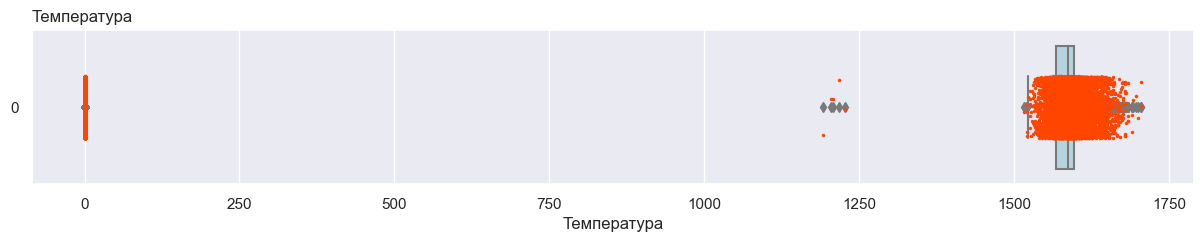

In [24]:
plot_box_strip(temp_new, temp_new.columns[2:], 'lightblue')

**Отфильтруем значения с аномально низкими температурами**

In [25]:
temp_anomaly = temp_new[temp_new['Температура'] <= 1500]
temp_anomaly.head(10)

,key,Время замера,Температура
4883,867,2019-06-06 08:03:39,1191.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0
13927,2500,2019-08-10 14:13:11,0.0
13928,2500,2019-08-10 14:18:12,0.0
13929,2500,2019-08-10 14:25:53,0.0
13930,2500,2019-08-10 14:29:39,0.0
13932,2501,2019-08-10 14:49:15,0.0
13933,2501,2019-08-10 15:02:56,0.0


Мы видим четыре аномальных значения с температурой ниже 1500 градусов в нескольких партиях, а также нулевые значения (отсутствие замеров мы заменили нулями выше в проекте), начиная с 2019-08-10 14:13:11	номер партии № 2500. Рассмотрим подробнее.  

**Построим графики температуры по времени и номеров партии по времени** 

Рассмотрим, как распределены во времени аномально низкие и нулевые (отсутсвие замеров с датчиков) значения температуры, а также вясним, какие партии были затронуты. Для этого выведем на экран график замеров температур по времени, а сверху наложим линию с номерами партии. 

Создадим две оси для наглядности, а также добавим точку, где произошо предполодительно отключение датчиков замера температуры.

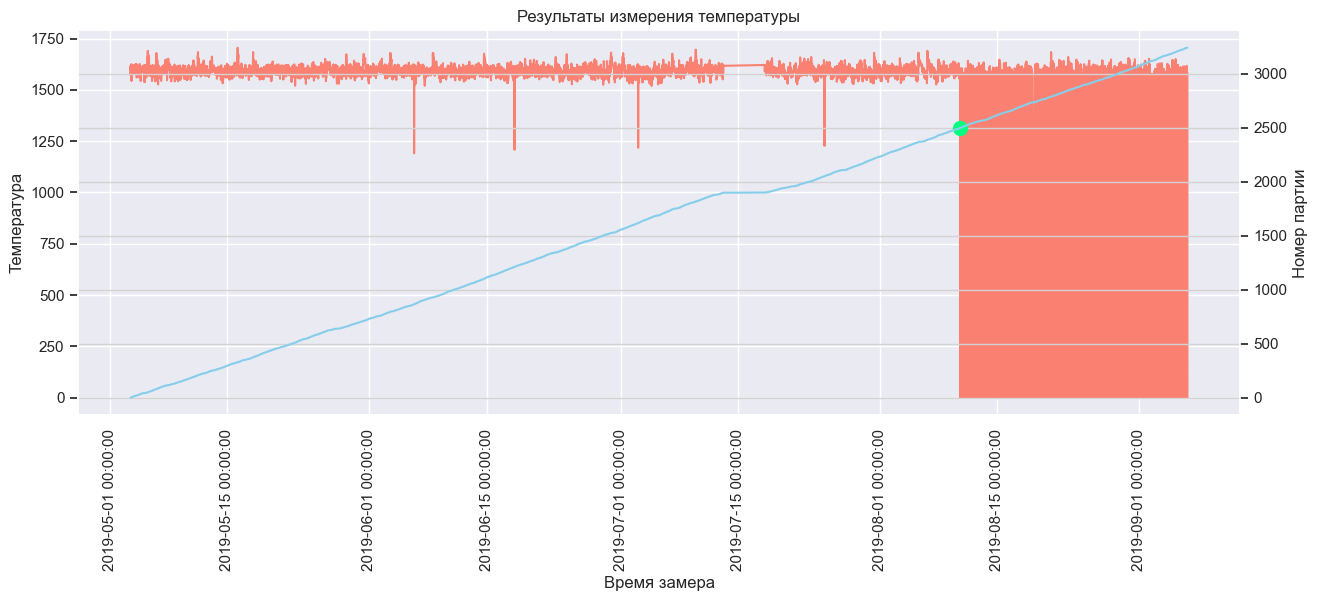

In [26]:
fig, ax1 = plt.subplots(figsize=(15, 5))

# Построение графика зависимости температуры от времени замера
ax1.plot(temp_new['Время замера'], temp_new['Температура'], color='salmon')
ax1.set_xlabel('Время замера')
ax1.set_ylabel('Температура')
ax1.set_title('Результаты измерения температуры')

# Создадим вторую ось и построим график номера партии
ax2 = ax1.twinx()
ax2.plot(temp_new['Время замера'], temp_new['key'], color='skyblue')
ax2.set_ylabel('Номер партии')
ax2.grid(color='lightgray')

# Изменим формат отображения даты на оси x, развернем даты вертикально
date_format = mdates.DateFormatter('%Y-%m-%d %H:%M:%S')
ax1.xaxis.set_major_formatter(date_format)
ax1.tick_params(axis='x', rotation=90)

# Добавление на график точку, где датчики замера температуры "отказали"
key_value = 2500
timestamp = pd.Timestamp('2019-08-10 14:13:11')
ax2.scatter(timestamp, key_value, color='springgreen', marker='o', s=100)

plt.show()

Теперь мы видим, что все пропуски сосредоточены в одной части датасета - начиная с 2500 партии, а также вилим единичные аномально низкие значения температуры в четырех точках ранее по времени.  

**Рассмотрим детально, какие замеры температур есть после 2500 партии**

Отфильтруем датасет по номеру партии (от 2500) и исключим нулевые значения). 

In [27]:
check = temp_new.query('key >= 2500 and Температура != 0')

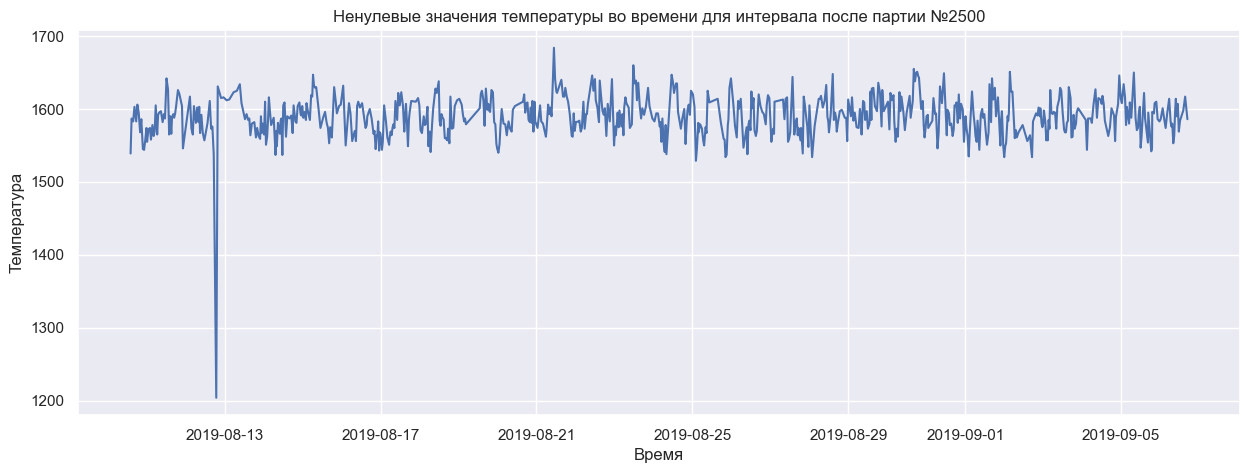

In [28]:
plt.figure(figsize = (15, 5))
plt.plot(check['Время замера'], check['Температура'])
plt.title('Ненулевые значения температуры во времени для интервала после партии №2500')
plt.xlabel('Время')
plt.ylabel('Температура')
plt.show()

Мы видим достаточно много замеров, но помотрим, подойдут ли они нам для дальнейей работы. 

In [29]:
check['key'].value_counts()

key
2500    1
2997    1
2988    1
2989    1
2990    1
       ..
2749    1
2750    1
2751    1
2752    1
3241    1
Name: count, Length: 739, dtype: int64

В рассматриваемом интервали 793 одиночных замера температуры. То есть для каждой партии в данном интервале у нас только один замер. Поскольку нет способа восстановить целевую температуру, данные замеры мы не сможем использовать в дальнейшей работе. Таким образом, мы должны удалить все данные после 2500 партии.  


**Удалим  замеры после 2500 партии** 

In [30]:
temp_new = temp_new.query('key < 2500') 

**Удалим целиком партии, содержащие температуры, ниже  1500** 

Для начала найдем эти партии и создадим из них условие для удаления. 

In [31]:
condition = temp_new['Температура'] <= 1500
values_to_remove = temp_new.loc[condition, 'key'].unique()
values_to_remove 

array([ 867, 1214, 1619, 2052], dtype=int64)

У нас все еще остались четыре партии (867, 1214, 1619, 2052), содержащие замеры ниже 1500 градусов. Удалим эти партии целиком. 

In [32]:
temp_new = temp_new[~temp_new['key'].isin(values_to_remove)]

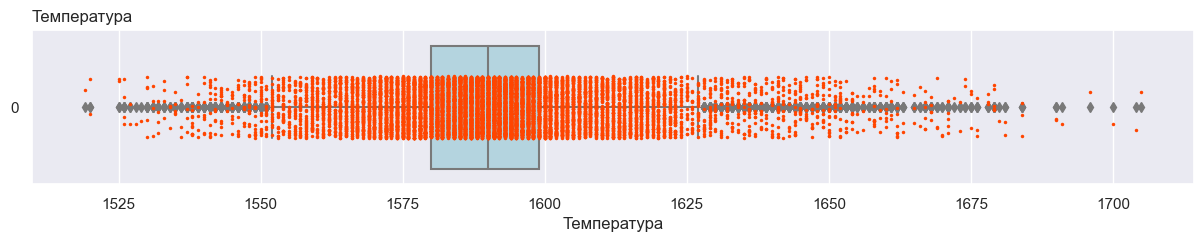

In [33]:
plot_box_strip(temp_new, temp_new.columns[2:], 'lightblue')

Аномальные температуры обработаны. 
Снова выведем график измерений температуры, чтобы удостовериться в адекватности данных. 

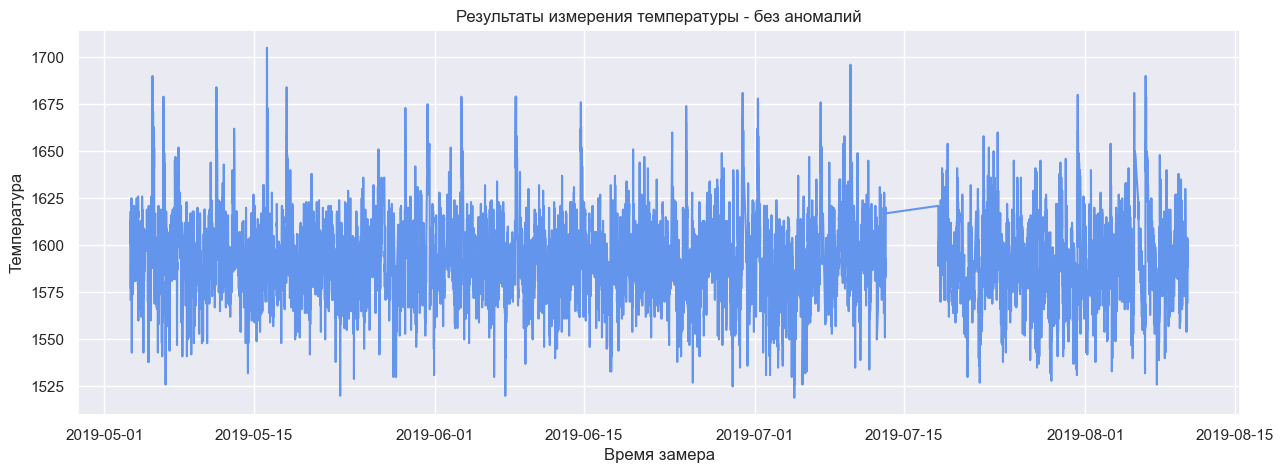

In [34]:
plt.figure(figsize = (15, 5))
plt.plot(temp_new['Время замера'], temp_new['Температура'], color='cornflowerblue')
plt.xlabel('Время замера')
plt.ylabel('Температура')
plt.title('Результаты измерения температуры - без аномалий')
plt.show()

#### Обработка аномальной Реактивной мощности (в датасете с данными об электродах)

Реактивная мощность в конкретном производственном процессе на может быть отрицательной. У нас в данных имеется экстремально низкое (отрицательное) значение реактивной мощности в -начении -715.479924, которое мы удалим. 

In [35]:
arc_new = arc_new.query('`Реактивная мощность` >= 0')

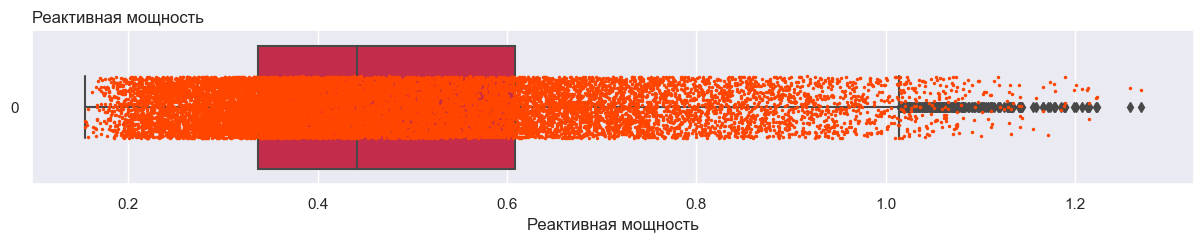

In [36]:
plot_box_strip(arc_new, arc_new.columns[-1:], 'crimson')

Аномалия реактивной мощности удалена успешно. 

### Генерация дополнительных признаков 

- Каждому признаку должен соответствовать один ключ (номер партии).
- Данне о времени мы используем в исследовании, но для модели они не требуются, потому временные метки можно исключить из признаков.


#### Признаки температуры и целевой признак

Для каждой партии у нас существует несколько замеров. 
- Промежуточные температуры нас не интересуют, в качестве признака можно взять начальную температуру, поскольку она всегда известна. 
- Конечная температура - целевой признак. 

In [37]:
temp_new.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


**Создадим таблицу с начальной и конечной температурой для каждой партии стали**

In [38]:
temp_processed = temp_new.pivot_table(index='key', values='Температура', aggfunc=["first", "last"])
temp_processed.columns = ['Начальная температура', 'Конечная температура']
temp_processed = temp_processed.reset_index()

In [39]:
display(temp_processed.head())
temp_processed.info()

,key,Начальная температура,Конечная температура
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2473 entries, 0 to 2472
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   key                    2473 non-null   int64  
 1   Начальная температура  2473 non-null   float64
 2   Конечная температура   2473 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 58.1 KB


На основе датасета, содержащего информацию о замерах температуры, получен новый датасет, содерджащий признак (начальную температуру) и целевой признак (конечную температуру) для каждой партии. 

#### Признаки мощности 
У нас присутствует несколько циклов нагрева для каждой партии. Нас интересует суммарное количество энергии, которое мы потратили на всю партию, независимо от промежуточных операций нагрева. 

In [40]:
arc_new.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


**Рссчитаем затраты энергии на каждую партию** 

Необходимо получить один признак из всех признаков для одного ключа (партии). Таким признаком будет затрченная на одну партию энергия. 
Энергия (работа) (W) может быть выражена через полную мощность (S) и время (t):

$$
W = S*t
$$

Полная мощность определяется как: 

$$
S = \sqrt{(P^2 + Q^2)}
$$

Следовательно, необходимый нам признак - энергия - рассчитывается по формуле: 

$$
W = t*\sqrt{(P^2 + Q^2)}
$$

где 
- *𝑊* - энергия, кВт.ч.
- *S* - полная_мощность, ВА
- *P* - активная_мощность, Вт
- *Q* - реактивная_мощность, ВАр 
- *t* - время, ч 

**Создадим новый датасет для признаков, на основе датаседа об электродах.**  

Рассчитаем время, затраченное на каждую операцию (построчно), переведем его в час (поскольку, расчеты правильно производить в системе СИ) и запишем в новый столбец: 

In [41]:
arc_processed = arc_new.copy()
arc_processed.loc[:, 'Время нагрева'] = (arc_processed['Конец нагрева дугой'] -
                                       arc_processed['Начало нагрева дугой']).dt.total_seconds() / 3600
arc_processed.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.063333
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.051389
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.047778
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.101389
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,0.041111


Рассчитаем полную мощность: 

In [42]:
arc_processed.loc[:, 'Полная мощность'] = (arc_processed['Активная мощность']**2 +
                                       arc_processed['Реактивная мощность']**2)**0.5
arc_processed.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева,Полная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.063333,0.371123
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.051389,0.902319
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.047778,0.722536
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.101389,0.642824
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,0.041111,1.079934


Рассчитаем энергию, затраченную на каждую операцию: 

In [43]:
arc_processed.loc[:, 'Энергия'] = (arc_processed['Время нагрева']*arc_processed['Полная мощность'])
arc_processed.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева,Полная мощность,Энергия
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.063333,0.371123,0.023504
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.051389,0.902319,0.046369
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.047778,0.722536,0.034521
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.101389,0.642824,0.065175
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,0.041111,1.079934,0.044397


**Создадим финальный датасет для данных по времени и энергии, потраченной на получение партии стали**

Для модели нам потребуется два признака - Энергия  и Время нагрева - удалим столбцы, которые использовались для ее расчета. То есть оставим только первый и два последних столбца.  

Сгруппируем данные по ключу 'key' и найдем суммарное значение времени и энергии, затраченной на производство каждой партии: 

In [44]:
arc_processed = arc_processed.iloc[:, [0, -3, -1]]
arc_grouped = arc_processed.groupby('key').agg({'Время нагрева': 'sum', 'Энергия': 'sum'}).reset_index()

In [45]:
arc_grouped.head()

,key,Время нагрева,Энергия
0,1,0.305000,0.213967
1,2,0.225278,0.133822
2,3,0.181944,0.200788
3,4,0.205833,0.189849
4,5,0.241389,0.142269


### Создание и анализ общей таблицы признаков 

#### Обьединим датасеты в общую таблицу признаков

Создадим список датасетов, которые мы будем обьединять: 

In [46]:
datasets = {'Энергия и время нагрева': arc_grouped,
            'Температура': temp_processed,
            'Сыпучие материалы': bulk_new,
            'Газ': gas_new,
            'Проволочные материалы': wire_new
            }

Напишем функцию для обьединения датасетов:  

In [47]:
def merge_datasets(datasets, key='key'):
    merged_data = None

    for dataset_name, dataset in datasets.items():
        if merged_data is None:
            merged_data = dataset
        else:
            merged_data = pd.merge(merged_data, dataset, on=key)

    return merged_data

Обьединим датасеты в общую таблицу признаков

In [48]:
merged_data = merge_datasets(datasets)

Приведем заголовки столбцов к snake_case и сделаем их с маленькой буквы, а также переименуем русскоязычные столбцы:

In [49]:
merged_data = merged_data.rename(columns={'Энергия': 'energy',
                                          'Время нагрева': 'hitting_time',
                                          'Начальная температура': 'start_temperature',
                                          'Конечная температура': 'final_temperature',
                                         'Газ 1': 'gas',})

merged_data.columns = merged_data.columns.str.lower().str.replace(' ', '_')

**Создадим еще один новый признак - кол-во газа в единицу времени для каждой партии - и удалим столбец с обьемом газа, который используем для расчета нового признака:**

In [50]:
merged_data.loc[:, 'gas_per_time'] = (merged_data['gas']/merged_data['hitting_time'])
merged_data = merged_data.drop(['gas'], axis=1)

merged_data.head()

,key,hitting_time,energy,start_temperature,final_temperature,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,gas_per_time
0,1,0.305000,0.213967,1571.0,1613.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97.540937
1,2,0.225278,0.133822,1581.0,1602.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.733686
2,3,0.181944,0.200788,1596.0,1599.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,156.942372
3,4,0.205833,0.189849,1601.0,1625.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.536288
4,5,0.241389,0.142269,1576.0,1602.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.427262


#### Проанализируем общую таблицу признаков

**Выведем основную информацию по общей таблице признаков**

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Общая таблица признаков ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


'Общая информация о датасете'

,key,hitting_time,energy,start_temperature,final_temperature,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,gas_per_time
0,1,0.305000,0.213967,1571.0,1613.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97.540937
1,2,0.225278,0.133822,1581.0,1602.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.733686
2,3,0.181944,0.200788,1596.0,1599.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,156.942372
3,4,0.205833,0.189849,1601.0,1625.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.536288
4,5,0.241389,0.142269,1576.0,1602.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.427262


,key,hitting_time,energy,start_temperature,final_temperature,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,gas_per_time
2320,2495,0.200833,0.192827,1570.0,1591.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.480840
2321,2496,0.261111,0.226616,1554.0,1591.0,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.048317
2322,2497,0.158056,0.228617,1571.0,1589.0,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.680347
2323,2498,0.208333,0.161614,1591.0,1594.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.777552
2324,2499,0.245278,0.147885,1569.0,1603.0,0.0,0.0,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,233.0,0.0,126.0,227.0,110.160958,50.00528,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.217602


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2325 entries, 0 to 2324
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                2325 non-null   int64  
 1   hitting_time       2325 non-null   float64
 2   energy             2325 non-null   float64
 3   start_temperature  2325 non-null   float64
 4   final_temperature  2325 non-null   float64
 5   bulk_1             2325 non-null   float64
 6   bulk_2             2325 non-null   float64
 7   bulk_3             2325 non-null   float64
 8   bulk_4             2325 non-null   float64
 9   bulk_5             2325 non-null   float64
 10  bulk_6             2325 non-null   float64
 11  bulk_7             2325 non-null   float64
 12  bulk_8             2325 non-null   float64
 13  bulk_9             2325 non-null   float64
 14  bulk_10            2325 non-null   float64
 15  bulk_11            2325 non-null   float64
 16  bulk_12            2325 

None

'Определим процент пропусков в датасете:'

key                  0.0
hitting_time         0.0
energy               0.0
start_temperature    0.0
final_temperature    0.0
bulk_1               0.0
bulk_2               0.0
bulk_3               0.0
bulk_4               0.0
bulk_5               0.0
bulk_6               0.0
bulk_7               0.0
bulk_8               0.0
bulk_9               0.0
bulk_10              0.0
bulk_11              0.0
bulk_12              0.0
bulk_13              0.0
bulk_14              0.0
bulk_15              0.0
wire_1               0.0
wire_2               0.0
wire_3               0.0
wire_4               0.0
wire_5               0.0
wire_6               0.0
wire_7               0.0
wire_8               0.0
wire_9               0.0
gas_per_time         0.0
dtype: float64

'Выведем описательную статистику и гистограммы числовых столбцов'

,key,hitting_time,energy,start_temperature,final_temperature,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,gas_per_time
count,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.0,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000
mean,1251.512258,0.224441,0.186128,1587.365161,1593.366022,3.433548,1.424946,47.296774,37.331613,2.644731,22.468817,2.008172,0.021075,0.445591,5.061505,4.252473,208.507957,1.069247,153.971613,120.026667,102.412198,17.605637,3.240481,0.307077,0.0,0.980504,0.006371,0.311847,0.317658,57.353907
std,715.099053,0.094691,0.088768,23.623144,11.209581,12.421994,19.098442,75.228262,58.670377,22.421296,55.831097,30.702509,1.016213,6.225965,20.934742,22.534166,157.137873,14.247231,81.398153,84.674380,43.535263,33.642919,27.966585,4.761821,0.0,8.700682,0.205882,4.406475,3.459510,40.285265
min,1.000000,0.015833,0.009286,1519.000000,1541.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.069970
25%,629.000000,0.161389,0.127187,1571.000000,1587.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,105.000000,0.000000,73.207679,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,34.935206
50%,1255.000000,0.216111,0.175254,1587.000000,1593.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,149.000000,107.000000,101.087998,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,48.106573
75%,1868.000000,0.275833,0.233790,1603.000000,1598.000000,0.000000,0.000000,80.000000,77.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,283.000000,0.000000,204.000000,204.000000,128.069763,23.102560,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,67.473946
max,2499.000000,1.163611,1.262891,1660.000000,1653.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000,330.314424,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,102.762401,62.025600,644.854621


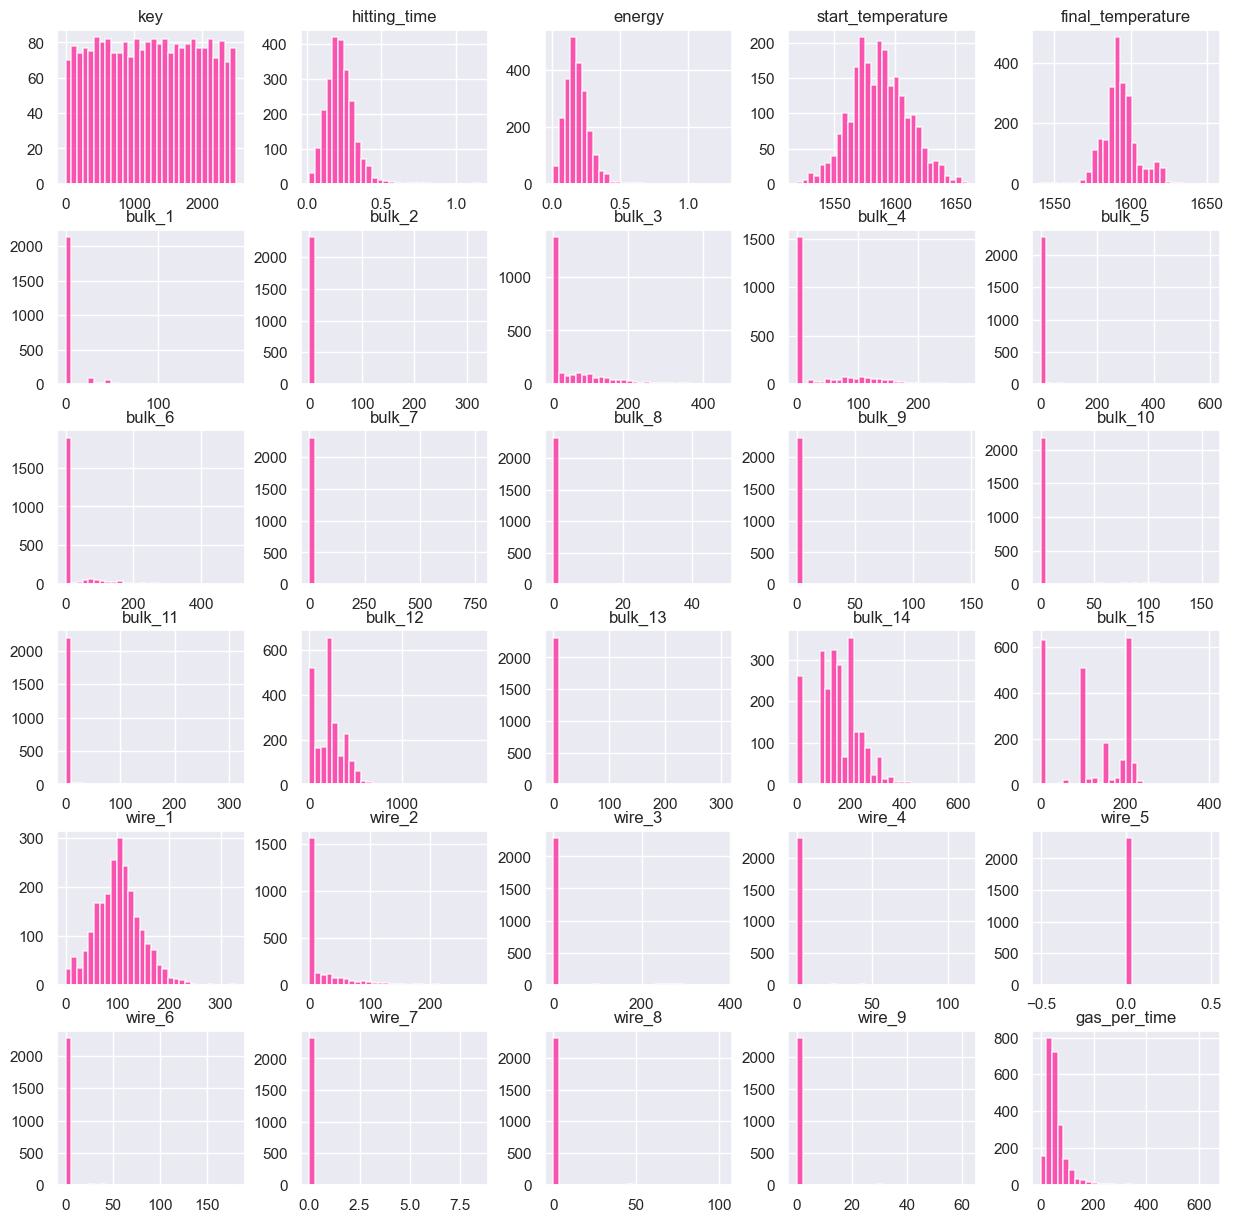

In [51]:
display_dataset_info(merged_data, "Общая таблица признаков", (15, 15), 'deeppink')

- Итоговый датасет состоит из 29 столбцов по 2325 строк, каждая из которых представляет изготовление одной партии стали (одному ключу соответствует один набор признаков) 
- Формат данных соответствует содержимому и подходит для дальнейшего анализа и обучения модели (изменения не требуются)
- Пропуски в датасете отстутствуют
- Распределение столбцов `Энергия`, `Конечная температура`, `Газ 1`, `Wire 1` похоже на распределение Пуассона со сдвигом влево, распределение столбца `Начальная температура` также похоже на распределение Пуассона.  Остальные столбцы содержат выбросы, которе обьясняются технологией производства (бОльшая часть спучих и проволочнх материалов практически не применялась при производстве за рассматриваемый период). 

 **Построим диаграммы размаха для каждого признака финальной таблицы**

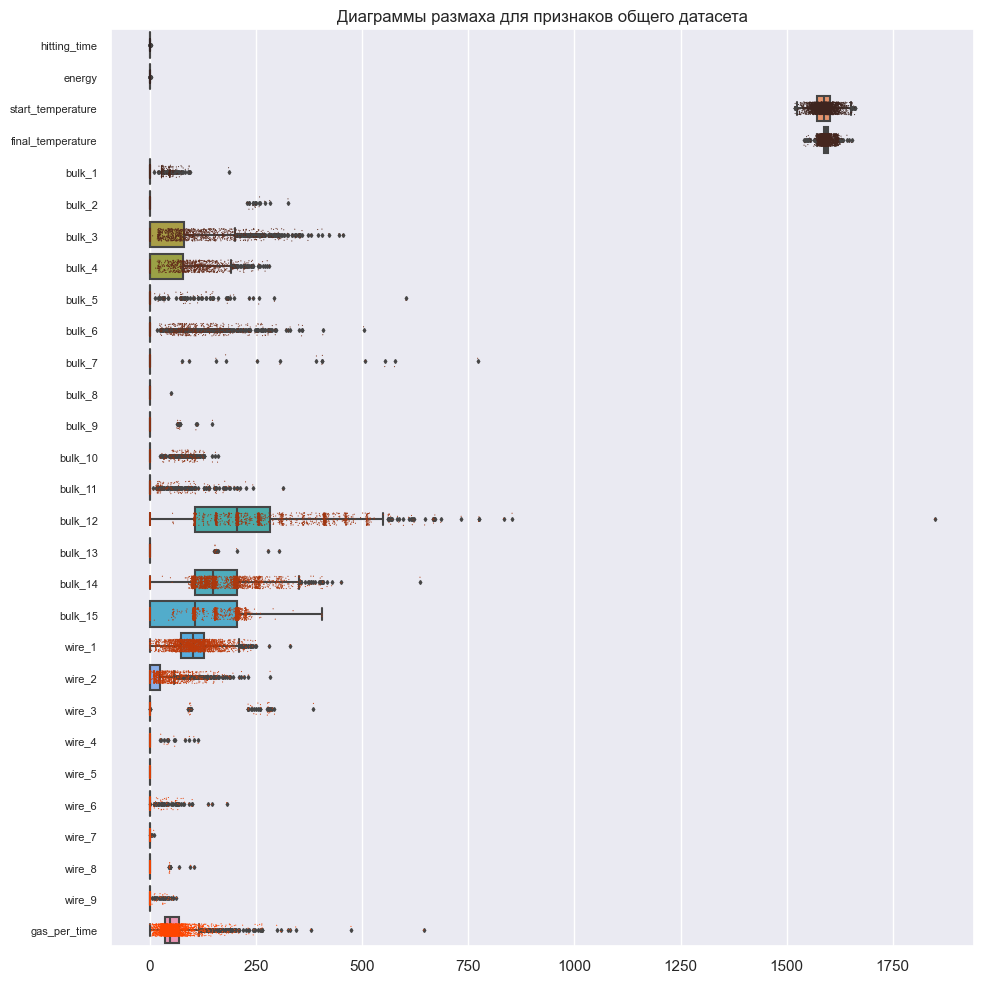

In [52]:
fig, ax = plt.subplots(figsize=(10, 10))
cols_to_plot = merged_data.columns[1:]
sns.boxplot(data=merged_data[cols_to_plot], ax=ax, orient='h',
           flierprops={'markersize': 2})
sns.stripplot(data=merged_data[cols_to_plot], orient="h", 
              palette='dark:orangered', jitter=0.2, size=0.8)
ax.tick_params(axis='y', labelsize=8)
ax.set_title('Диаграммы размаха для признаков общего датасета')
plt.tight_layout()
plt.show()

- Из диаграмм размаха видно, что большая часть материалов (сыпучих и проволочных) крайне редко используется в производстве. Редкие случаи применения выглядят как выбросы. 
- Наиболее часто встречаются материалы Bulk 3, 4, 12, 14, 15 и Wire 1, 2. 
- Распредетние температуры (начальная и конечная), энергии и газа ближе к нормальному.  

**Рассмотрим корреляцию признаков**

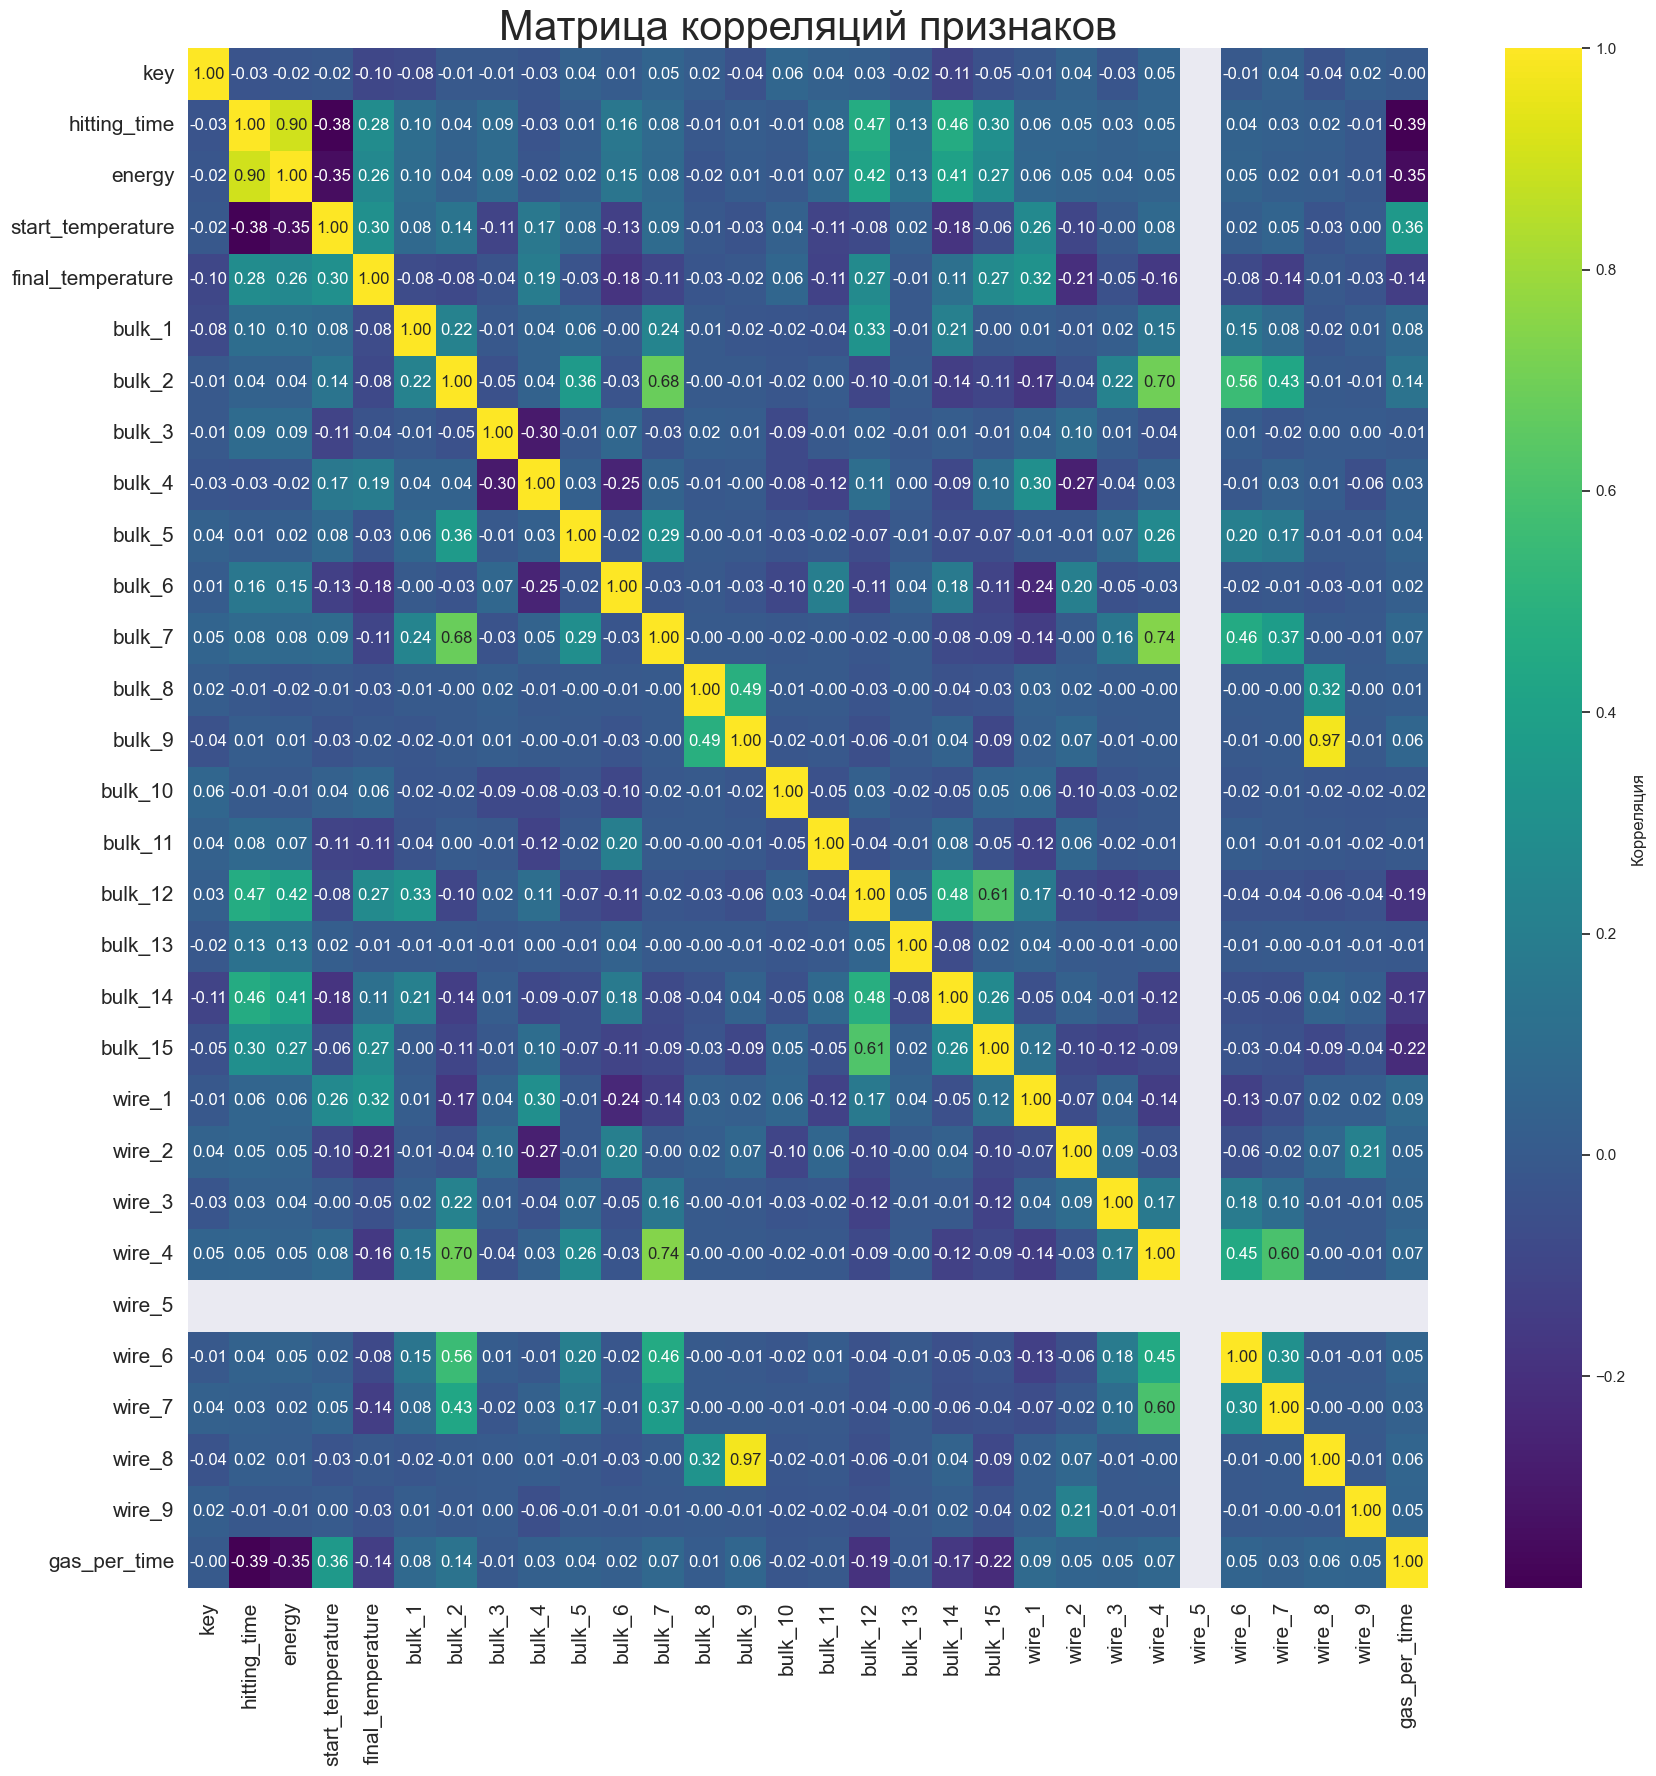

In [53]:
plt.figure(figsize=(20, 20))
plt.title('Матрица корреляций признаков', fontsize=30)
heatmap = sns.heatmap(merged_data.corr(), cmap='viridis', annot=True, fmt='.2f', cbar_kws={'label': 'Корреляция'})
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=15)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=15)
plt.show()

**Для комментариев силы связи между признаками используем [шкалу Чеддока](https://statpsy.ru/correlation/velicina/)**

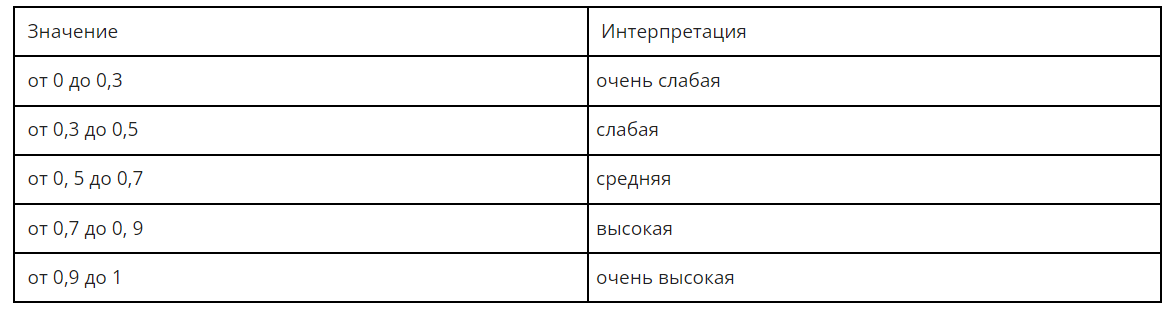

- БОльшая часть признаков имеет очень слабую и слабую корреляцию. 
- Некоторые материалы имеют среднюю (Wire 4 и Bulk 2, Wire 6 и Bulk 2, Bulk 2 и Bulk 7, Wire 7 и Wire 4, Bulk 12 и Bulk 15), высокую (Bulk 9 и Wire 8, Wire 7 и Wire 4) и очень высокую (Bulk 9 и Wire 8) корреляцию, что можно обьяснить технологическим процессом производства стали (например, конкретный легирующий состав, материалы сгруппированы).  
- Энергия практически не связана с другими параметрами, наибольшая взаимосвязь:
  - слабая корреляция Энергии с материалами Bulk 12, Bulk 14 и Газ (вероятная причина - на расплавление некоторых тугоплавких легирующих элементов требуется больше энергии)
  - слабая отрицательная корреляция Энергии с Начальной температурой (что логично, чем выше температура первого замера, тем меньше суммарной энергии на разогрев нужно) 
- Начальная и Кончная температура имеют слабую корреляцию. Можно предположить, что для более тугоплавких составов нужен булее высокий температурный диапазон. 

**Устраним мультиколлинеарность признаков wire_8 и bulk_9 с высокой корреляцией 0.97**

Из матрицы корреляции можно увидеть, что материалы wire_8 и bulk_9 сильно связаны. Верояно, в технологическом процессе они оба учасвтвуют при изготовлении стали с конкретным составом. Создадим новый признак, который включает оба этих материала. 

In [54]:
merged_data = merged_data.copy()
merged_data.loc[:, 'wire8_bulk9'] = (merged_data['wire_8'] + merged_data['bulk_9'])

Удалим столбц, сумму которых м добавили в новый признак. 

In [55]:
merged_data = merged_data.drop(['wire_8'], axis=1)
merged_data = merged_data.drop(['bulk_9'], axis=1)

merged_data.head()

,key,hitting_time,energy,start_temperature,final_temperature,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_9,gas_per_time,wire8_bulk9
0,1,0.305000,0.213967,1571.0,1613.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,97.540937,0.0
1,2,0.225278,0.133822,1581.0,1602.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,55.733686,0.0
2,3,0.181944,0.200788,1596.0,1599.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,156.942372,0.0
3,4,0.205833,0.189849,1601.0,1625.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,91.536288,0.0
4,5,0.241389,0.142269,1576.0,1602.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,22.427262,0.0


<a id='Предобработка_данных'></a>
 
**ВЫВОД:**

**Предобработка данных**
- Пропуски в датасетах заменены нулевыми значениями
- Все столбцы с временем преобразован в формат datetime
- Обработаны аномалии 
- удалены аномальные значения температуры ниже 1500 градусов, 
- удалено экстремально низкое значение реактивной мощности 
- Сгенерированы дополнительные признаки: 
- Признаки температуры (Начальная температура) и целевой признак (Конечная температура)
- Признак Энергия - рассчитан из полной мощности и времени нагрева
- Создана таблица признаков, которая включает новые признаки (Энергия, Начальная и Конечная температуры), обьемы спучих и проволочных метериалов, и информацию по Газу.

**Анализ таблицы признаков**

- Итоговый датасет состоит из 29 столбцов по 2329 строк, каждая из которых представляет изготовление одной партии стали (одному ключу соответствует один набор признаков) 
- Распределение столбцов `energy`, `final_temperature`, `gas`, `Wire 1` похоже на распределение Пуассона со сдвигом влево, распределение столбца `start_temperature` также похоже на распределение Пуассона.  Остальные столбцы содержат выбросы, которе обьясняются технологией производства (бОльшая часть спучих и проволочнх материалов практически не применялась при производстве за рассматриваемый период). 
- Из диаграмм размаха видно, что большая часть материалов (сыпучих и проволочных) крайне редко используется в производстве. Редкие случаи применения выглядят как выбросы. Наиболее часто встречаются материалы Bulk 3, 4, 12, 14, 15 и Wire 1, 2. 
- БОльшая часть признаков имеет слабую и очень слабую и слабую корреляцию. Некоторые материалы имеют среднюю (Wire 6 и Bulk 2, Bulk 2 и Bulk 7) и высокую (Bulk 9 и Wire 8, Wire 7 и Wire 4)  и очень высокую (Bulk 9 и Wire 8) корреляцию, что можно обьяснить технологическим процессом производства стали (например, конкретный легирующий состав, материалы сгруппированы).  
- Энергия практически не коррелирует с другими параметрами, наибольшая взаимосвязь:
  - слабая корреляция Энергии с материалами Bulk 12, Bulk 14 и Газ (вероятная причина - на расплавление некоторых тугоплавких легирующих элементов требуется больше энергии)
  - слабая отрицательная корреляция Энергии с Начальной температурой (что логично, чем выше температура первого замера, тем меньше суммарной энергии на разогрев нужно) 
- Начальная и Кончная температура имеют слабую корреляцию. Можно предположить, что для более тугоплавких составов нужен булее высокий температурный диапазон. 

**Добавление признаков** 

Материалы wire_8 и bulk_9 сильно коррелируют, можем предположить, в технологическом процессе они оба учасвтвуют при изготовлении стали с конкретным составом. Создали новый признак, который включает оба этих материала (суммарный обьем).
_____________________________________________________________________________________________________________________________

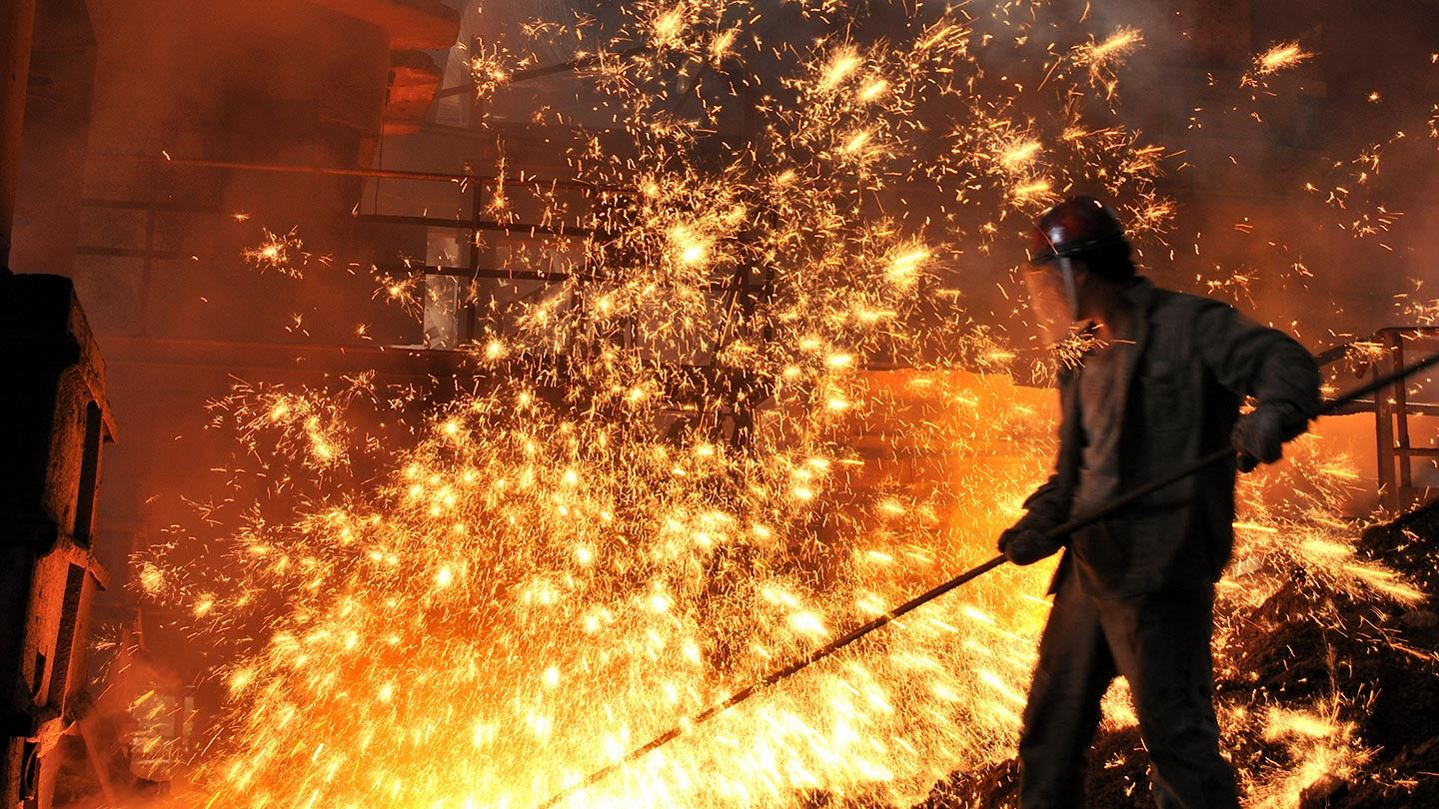